In [155]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from ml_time_series import generate_envelope
import timeit
from datetime import datetime
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import math as m

%matplotlib notebook

### Filtering

In [2]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [3]:
def plot_fremg(FILE_,Xc):    
    
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(Xc[:, 0], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 1')

    # pass sharey=ax1 to ensure the two subplots share the same y axis
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 1], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 2')

    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 2], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 3')
    
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(Xc[:, 3], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 4')
    
    #fig_name = FILE_+'_filtered'+str(180)+'.png'
    fig.set_size_inches(w=10,h=7)
    #fig.savefig('./graphs/'+fig_name)

### FFT

In [4]:
def plot_fft(Xc, fs):
    X =np.abs(np.fft.fft(Xc[:, 0]))
    f =np.linspace(0, fs,Xc[:, 0].shape[0])
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    plt.title('FFT')

    # pass sharey=ax1 to ensure the two subplots share the same y axis
    X =np.abs(np.fft.fft(Xc[:, 1]))
    f =np.linspace(0, fs,Xc[:, 1].shape[0])
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 2')

    X =np.abs(np.fft.fft(Xc[:, 2]))
    f =np.linspace(0, fs,Xc[:, 2].shape[0])
    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 3')
    
    X =np.abs(np.fft.fft(Xc[:, 3]))
    f =np.linspace(0, fs,Xc[:, 3].shape[0])
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 4')
    
    fig.set_size_inches(w=10,h=7)

In [24]:
files_w = ['data_w_1', 'data_w_2', 'data_w_3', 'data_w_4', 'data_w_5', 'data_w_6', 'data_w_7', 'data_w_8', 'data_w_9', 
           'data_w_10', 'data_w_11', 'data_w_12']
files_r = ['data_r_1', 'data_r_2', 'data_r_3', 'data_r_4', 'data_r_5', 'data_r_6', 'data_r_7', 'data_r_8', 'data_r_9', 
           'data_r_10', 'data_r_11', 'data_r_12']
files_us = ['data_us_1', 'data_us_2', 'data_us_3', 'data_us_4', 'data_us_5', 'data_us_6', 'data_us_7', 'data_us_8', 
            'data_us_9', 'data_us_10', 'data_us_11', 'data_us_12']
files_ds = ['data_ds_1', 'data_ds_2', 'data_ds_3', 'data_ds_4', 'data_ds_5', 'data_ds_6', 'data_ds_7', 'data_ds_8', 
            'data_ds_9', 'data_ds_10', 'data_ds_11', 'data_ds_12']


<IPython.core.display.Javascript object>


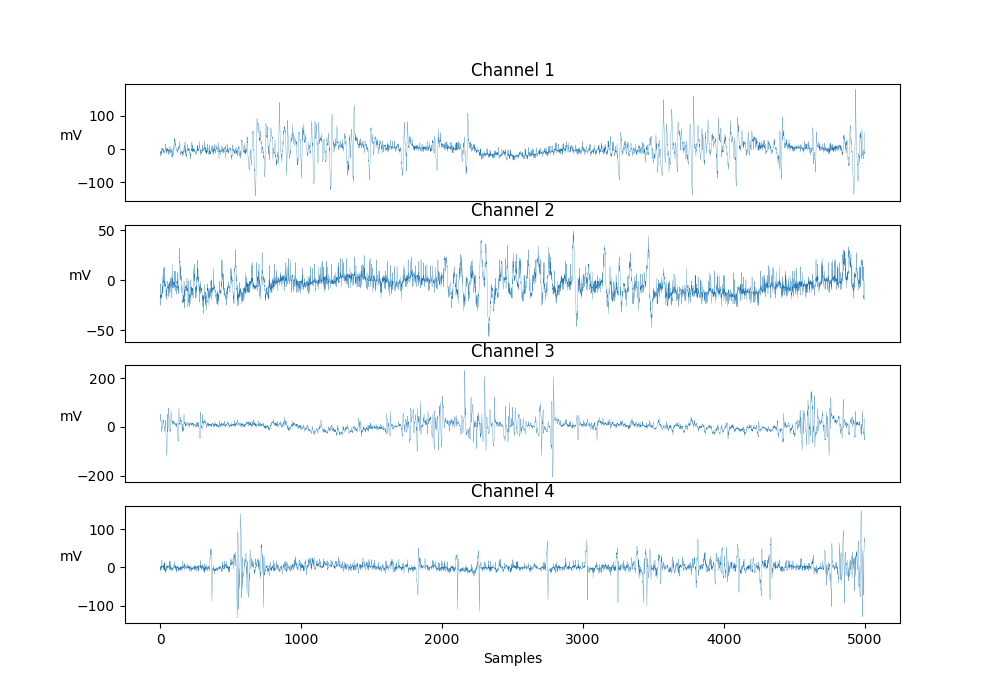


Xc shape  ()


In [57]:
FILE_ = files_w[0]

X = np.genfromtxt('DB_GAIT/'+FILE_+'.txt', delimiter=",", usecols=(1,2,3,4))

plot_fremg(FILE_,X)
print '\nXc shape ', Xc.shape

### RMS

$\hat{x} = \sqrt{\frac{1}{N}\sum_{k=1}^{N}\left[ x(k) \right]^2} \mapsto k=1,2,\dots , N$

In [38]:
import numpy as np
def rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

<IPython.core.display.Javascript object>


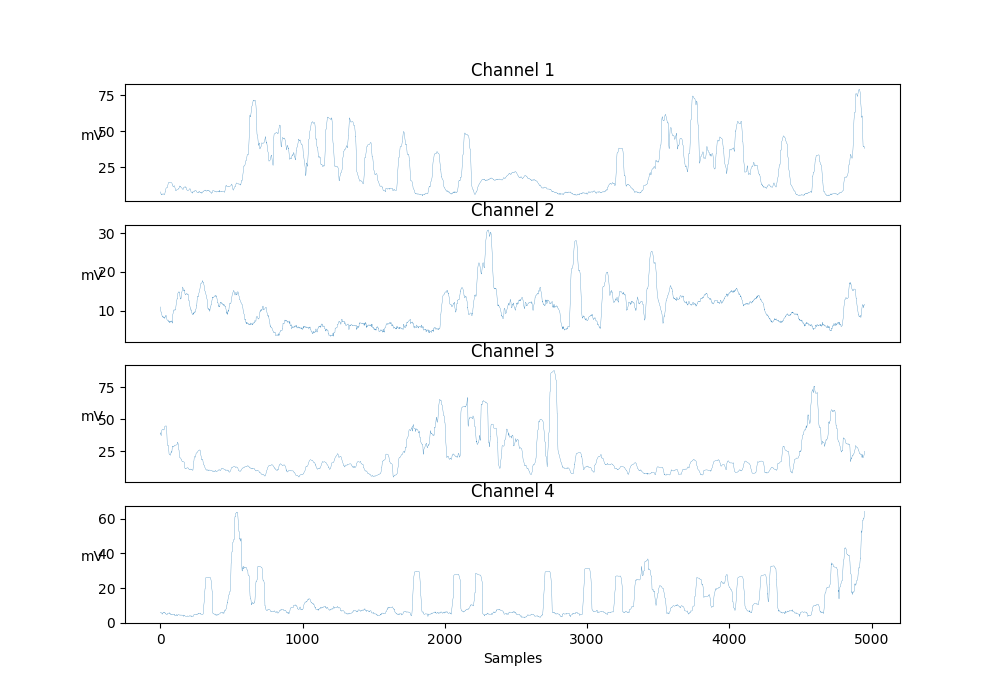


Xc shape  (4952, 4)


In [59]:
for i in range(X.shape[1]):
    if i == 0:
        Xc = rms(X[:, i], 50)
    else:
        Xcp = rms(X[:, i], 50)
        Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_, Xc)
print '\nXc shape ', Xc.shape

### MAV

$\bar{x} = \frac{1}{N}\sum_{k=1}^{N-1} |x(k)|$

In [41]:
def mav(a, window_size):
    window = np.ones(window_size)/float(window_size)
    return np.abs(np.convolve(a, window, 'valid'))

<IPython.core.display.Javascript object>


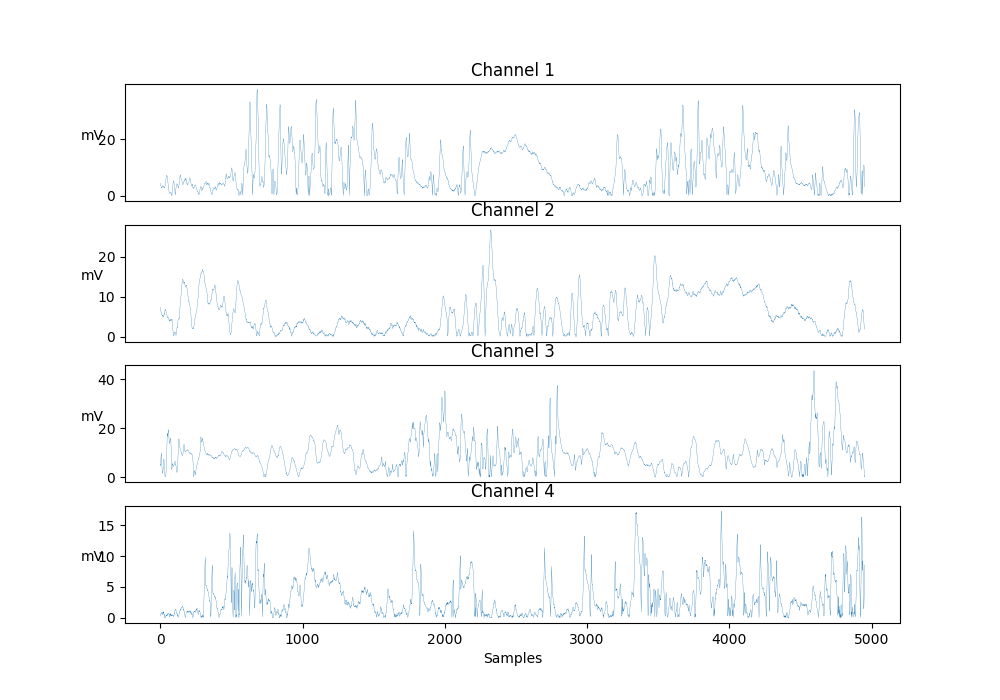


Xc shape  (4952, 4)


In [62]:
for i in range(X.shape[1]):
    if i == 0:
        Xc = mav(X[:, i], 50)
        #plot_fremg(FILE_, Xc)
    else:
        Xcp = mav(X[:, i], 50)
        #plot_fremg(FILE_, Xcp)
        Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_, Xc)
print '\nXc shape ', Xc.shape

### VAR

$\sigma^{2}_{i} = \frac{1}{N-1}\sum_{k=0}^{N-1} ( x(k) - \bar{x} (i)  ) ^{2}$

$\bar{x}(i) = \frac{1}{N}\sum_{k=0}^{N-1} x(i-k)$

In [143]:
def f_var(a, window_size):
    Z = np.array([])
    for i in range(len(a)-window_size):
        Z = np.append(Z,np.var(a[i:window_size+i]))
    return Z

<IPython.core.display.Javascript object>


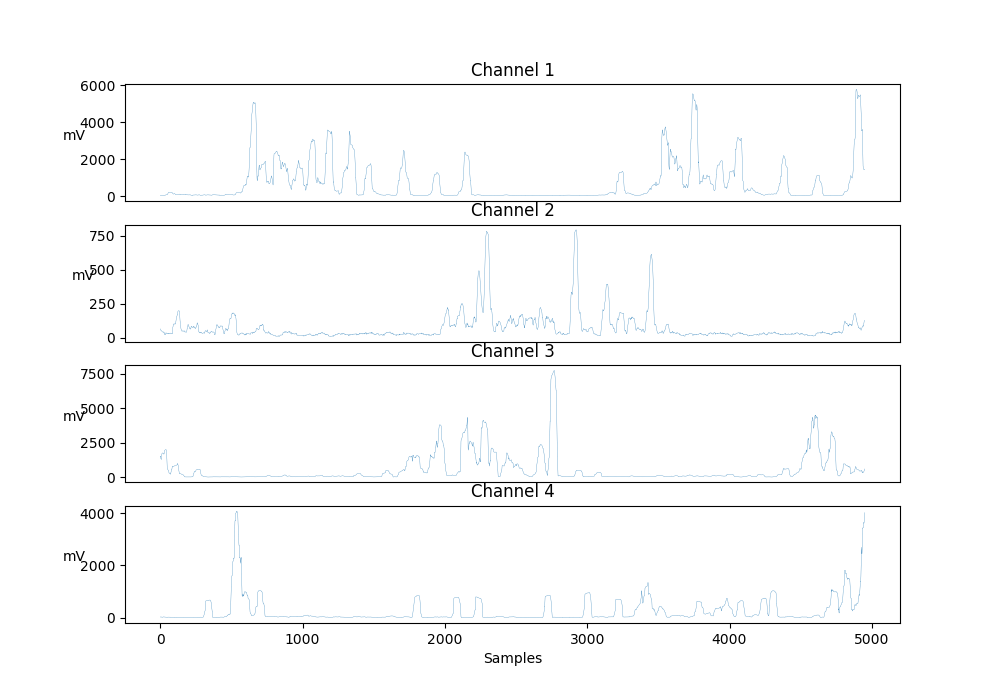


Xc shape  (4951, 4)


In [144]:
for i in range(X.shape[1]):
    if i == 0:
        Xc = f_var(X[:, i], 50)
    else:
        Xcp = f_var(X[:, i], 50)
        Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_, Xc)

print '\nXc shape ', Xc.shape

### Entropy

$H(\sigma_{i})=\frac{1}{2}log_{2}\left( 2\pi e \sigma^{2}_{i} \right)$

$\sigma^{2}_{i} = \frac{1}{N-1}\sum_{n=1}^{N} x_{i}(n)^{2}$

<IPython.core.display.Javascript object>


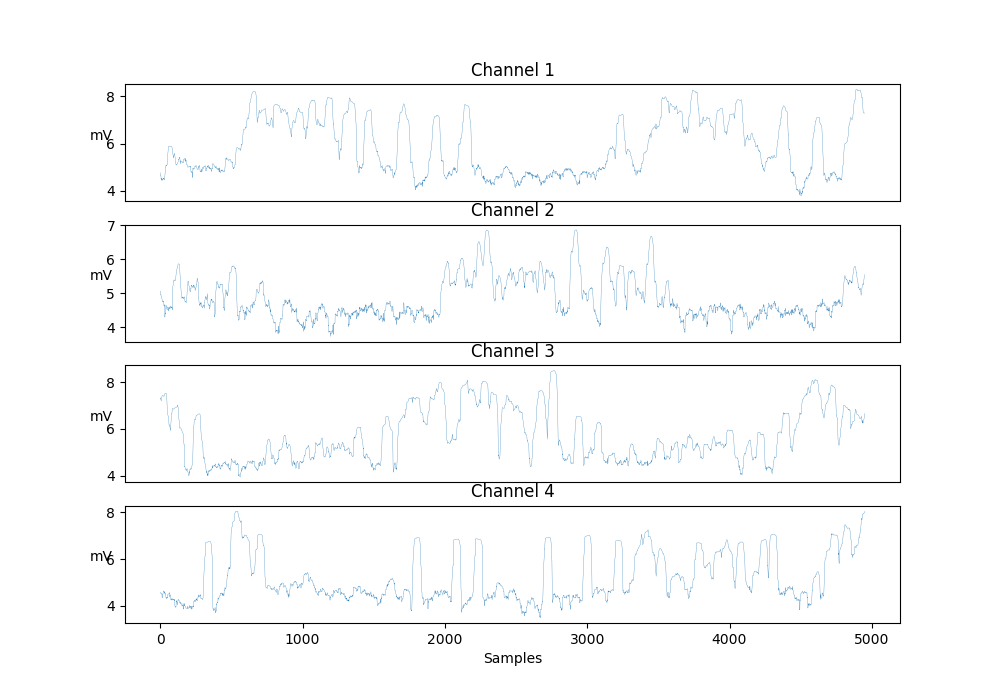

In [210]:
e = []


for j in range(X.shape[1]):
    if j == 0:
        for i in range(Xc.shape[0]):
            e.append((m.log(2*m.pi*m.exp(1)*Xc[i,j],2))/2)
        e = np.array(e)

    else:
        ep = []
        for i in range(Xc.shape[0]):
            ep.append((m.log(2*m.pi*m.exp(1)*Xc[i,j],2))/2)
        ep = np.array(ep)
        e = np.vstack((e,ep))

        
e = np.transpose(e)
plot_fremg(FILE_, e)

#e = []
#for i in range(Xc.shape[0]):
#    e.append((m.log(2*m.pi*m.exp(1)*Xc[i,1],2))/2)

#e = np.array(e)

#plt.plot(e, linewidth=0.2)
#plt.xlabel('Frequency')
#plt.ylabel('mV').set_rotation(0)

In [208]:
e.shape

(4, 4951)

<IPython.core.display.Javascript object>


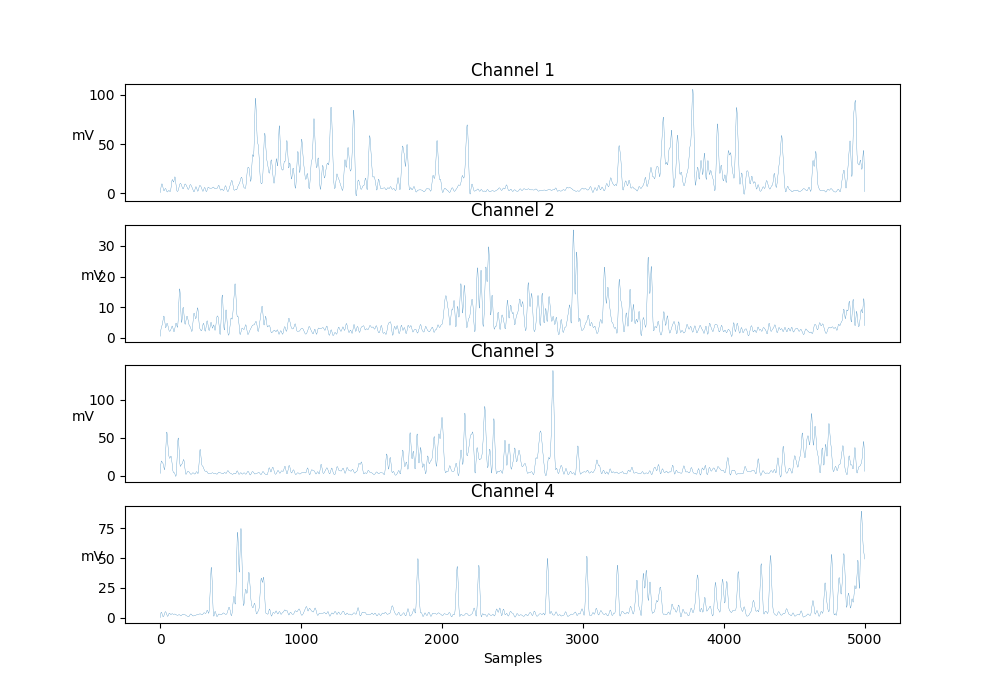


Xc shape  (5001, 4)


In [31]:
for i in range(X.shape[1]):
    if i == 0:
        Xc = filter_signal(X[:, i], low_pass=180)
        #plot_fremg(FILE_, Xc)
    else:
        Xcp = filter_signal(X[:, i], low_pass=180)
        #plot_fremg(FILE_, Xcp)
        Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_, Xc)

print '\nXc shape ', Xc.shape

$\frac{3}{3}$